# Bangkok air quality: Time Series data analysis using lightGBM regressor
* Notebook: https://github.com/prasertcbs/scikitlearn_tutorial/blob/main/notebook/regressor_air_quality.ipynb
* data source: https://aqicn.org/data-platform/register/

---
* author:  [Prasert Kanawattanachai](prasert.k@chula.ac.th)
* YouTube: https://www.youtube.com/prasertcbs
* github: https://github.com/prasertcbs/
* [Chulalongkorn Business School](https://www.cbs.chula.ac.th/en/)
---

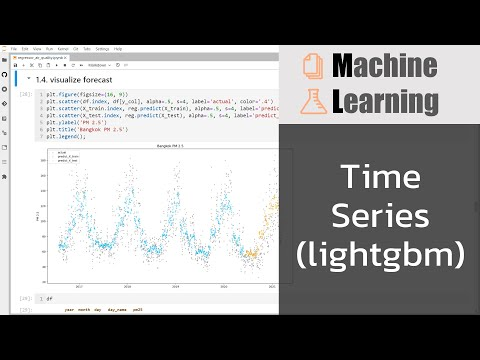

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo('COtinIQk12w', width=720, height=405)

In [1]:
import sys
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
print(f'Python  version: {sys.version}')
print(f'pandas  version: {pd.__version__}')
print(f'numpy   version: {np.__version__}')

Python  version: 3.11.1 (main, Dec 23 2022, 09:40:27) [Clang 14.0.0 (clang-1400.0.29.202)]
pandas  version: 2.0.3
numpy   version: 1.24.4


## read and preprocess data

In [4]:
data_url='https://github.com/prasertcbs/basic-dataset/raw/master/bangkok-air-quality.csv'
data=pd.read_csv(data_url, parse_dates=['date'], na_values=[' '], skipinitialspace=True)
data

,date,pm25,pm10,o3,no2,so2,co
0,2021-03-01,93.0,30.0,8.0,6.0,1.0,NaN
1,2021-03-02,68.0,27.0,7.0,5.0,1.0,NaN
2,2021-03-03,58.0,37.0,13.0,9.0,1.0,NaN
3,2021-03-04,74.0,35.0,13.0,6.0,NaN,NaN
4,2021-03-05,72.0,38.0,15.0,6.0,1.0,NaN
...,...,...,...,...,...,...,...
2619,2015-03-15,NaN,NaN,23.0,13.0,3.0,9.0
2620,2014-11-30,NaN,NaN,40.0,36.0,4.0,11.0
2621,2013-12-31,NaN,NaN,68.0,33.0,3.0,7.0
2622,2014-01-26,NaN,NaN,54.0,53.0,6.0,18.0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2624 entries, 0 to 2623
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    2624 non-null   datetime64[ns]
 1   pm25    1680 non-null   float64       
 2   pm10    2609 non-null   float64       
 3   o3      2610 non-null   float64       
 4   no2     2611 non-null   float64       
 5   so2     1877 non-null   float64       
 6   co      963 non-null    float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 143.6 KB


In [6]:
data=data.sort_values('date').reset_index(drop=True).copy()
data

,date,pm25,pm10,o3,no2,so2,co
0,2013-12-31,NaN,NaN,68.0,33.0,3.0,7.0
1,2014-01-01,NaN,84.0,90.0,48.0,5.0,16.0
2,2014-01-02,NaN,84.0,119.0,63.0,7.0,14.0
3,2014-01-03,NaN,103.0,95.0,57.0,7.0,13.0
4,2014-01-04,NaN,101.0,52.0,34.0,1.0,NaN
...,...,...,...,...,...,...,...
2619,2021-03-10,98.0,53.0,16.0,12.0,1.0,NaN
2620,2021-03-11,111.0,52.0,19.0,10.0,NaN,NaN
2621,2021-03-12,101.0,48.0,15.0,7.0,1.0,NaN
2622,2021-03-13,96.0,32.0,9.0,4.0,1.0,NaN


In [7]:
y_col='pm25'

In [8]:
data.dropna(subset=[y_col], inplace=True)
data=data.reset_index(drop=True)
data

,date,pm25,pm10,o3,no2,so2,co
0,2016-07-30,61.0,19.0,17.0,15.0,8.0,6.0
1,2016-07-31,68.0,24.0,25.0,13.0,7.0,6.0
2,2016-08-01,60.0,20.0,26.0,14.0,2.0,6.0
3,2016-08-02,68.0,25.0,21.0,14.0,7.0,6.0
4,2016-08-03,70.0,26.0,23.0,16.0,2.0,6.0
...,...,...,...,...,...,...,...
1675,2021-03-10,98.0,53.0,16.0,12.0,1.0,NaN
1676,2021-03-11,111.0,52.0,19.0,10.0,NaN,NaN
1677,2021-03-12,101.0,48.0,15.0,7.0,1.0,NaN
1678,2021-03-13,96.0,32.0,9.0,4.0,1.0,NaN


In [9]:
def date_parts(data, date_colname='date'):
    '''create year, month, day, dayname columns'''
    data['year']=data['date'].dt.year
    data['month']=data['date'].dt.month
    data['day']=data['date'].dt.day
    data['day_name']=data['date'].dt.day_name().astype('category')

In [10]:
date_parts(data)

In [11]:
data

,date,pm25,pm10,o3,no2,so2,co,year,month,day,day_name
0,2016-07-30,61.0,19.0,17.0,15.0,8.0,6.0,2016,7,30,Saturday
1,2016-07-31,68.0,24.0,25.0,13.0,7.0,6.0,2016,7,31,Sunday
2,2016-08-01,60.0,20.0,26.0,14.0,2.0,6.0,2016,8,1,Monday
3,2016-08-02,68.0,25.0,21.0,14.0,7.0,6.0,2016,8,2,Tuesday
4,2016-08-03,70.0,26.0,23.0,16.0,2.0,6.0,2016,8,3,Wednesday
...,...,...,...,...,...,...,...,...,...,...,...
1675,2021-03-10,98.0,53.0,16.0,12.0,1.0,NaN,2021,3,10,Wednesday
1676,2021-03-11,111.0,52.0,19.0,10.0,NaN,NaN,2021,3,11,Thursday
1677,2021-03-12,101.0,48.0,15.0,7.0,1.0,NaN,2021,3,12,Friday
1678,2021-03-13,96.0,32.0,9.0,4.0,1.0,NaN,2021,3,13,Saturday


In [12]:
data.columns

Index(['date', 'pm25', 'pm10', 'o3', 'no2', 'so2', 'co', 'year', 'month',
       'day', 'day_name'],
      dtype='object')

In [13]:
df=data[['date', 'year', 'month', 'day', 'day_name', y_col]]
df

,date,year,month,day,day_name,pm25
0,2016-07-30,2016,7,30,Saturday,61.0
1,2016-07-31,2016,7,31,Sunday,68.0
2,2016-08-01,2016,8,1,Monday,60.0
3,2016-08-02,2016,8,2,Tuesday,68.0
4,2016-08-03,2016,8,3,Wednesday,70.0
...,...,...,...,...,...,...
1675,2021-03-10,2021,3,10,Wednesday,98.0
1676,2021-03-11,2021,3,11,Thursday,111.0
1677,2021-03-12,2021,3,12,Friday,101.0
1678,2021-03-13,2021,3,13,Saturday,96.0


In [14]:
df=df.set_index('date')
df

,year,month,day,day_name,pm25
date,,,,,
2016-07-30,2016,7,30,Saturday,61.0
2016-07-31,2016,7,31,Sunday,68.0
2016-08-01,2016,8,1,Monday,60.0
2016-08-02,2016,8,2,Tuesday,68.0
2016-08-03,2016,8,3,Wednesday,70.0
...,...,...,...,...,...
2021-03-10,2021,3,10,Wednesday,98.0
2021-03-11,2021,3,11,Thursday,111.0
2021-03-12,2021,3,12,Friday,101.0


## visualize data

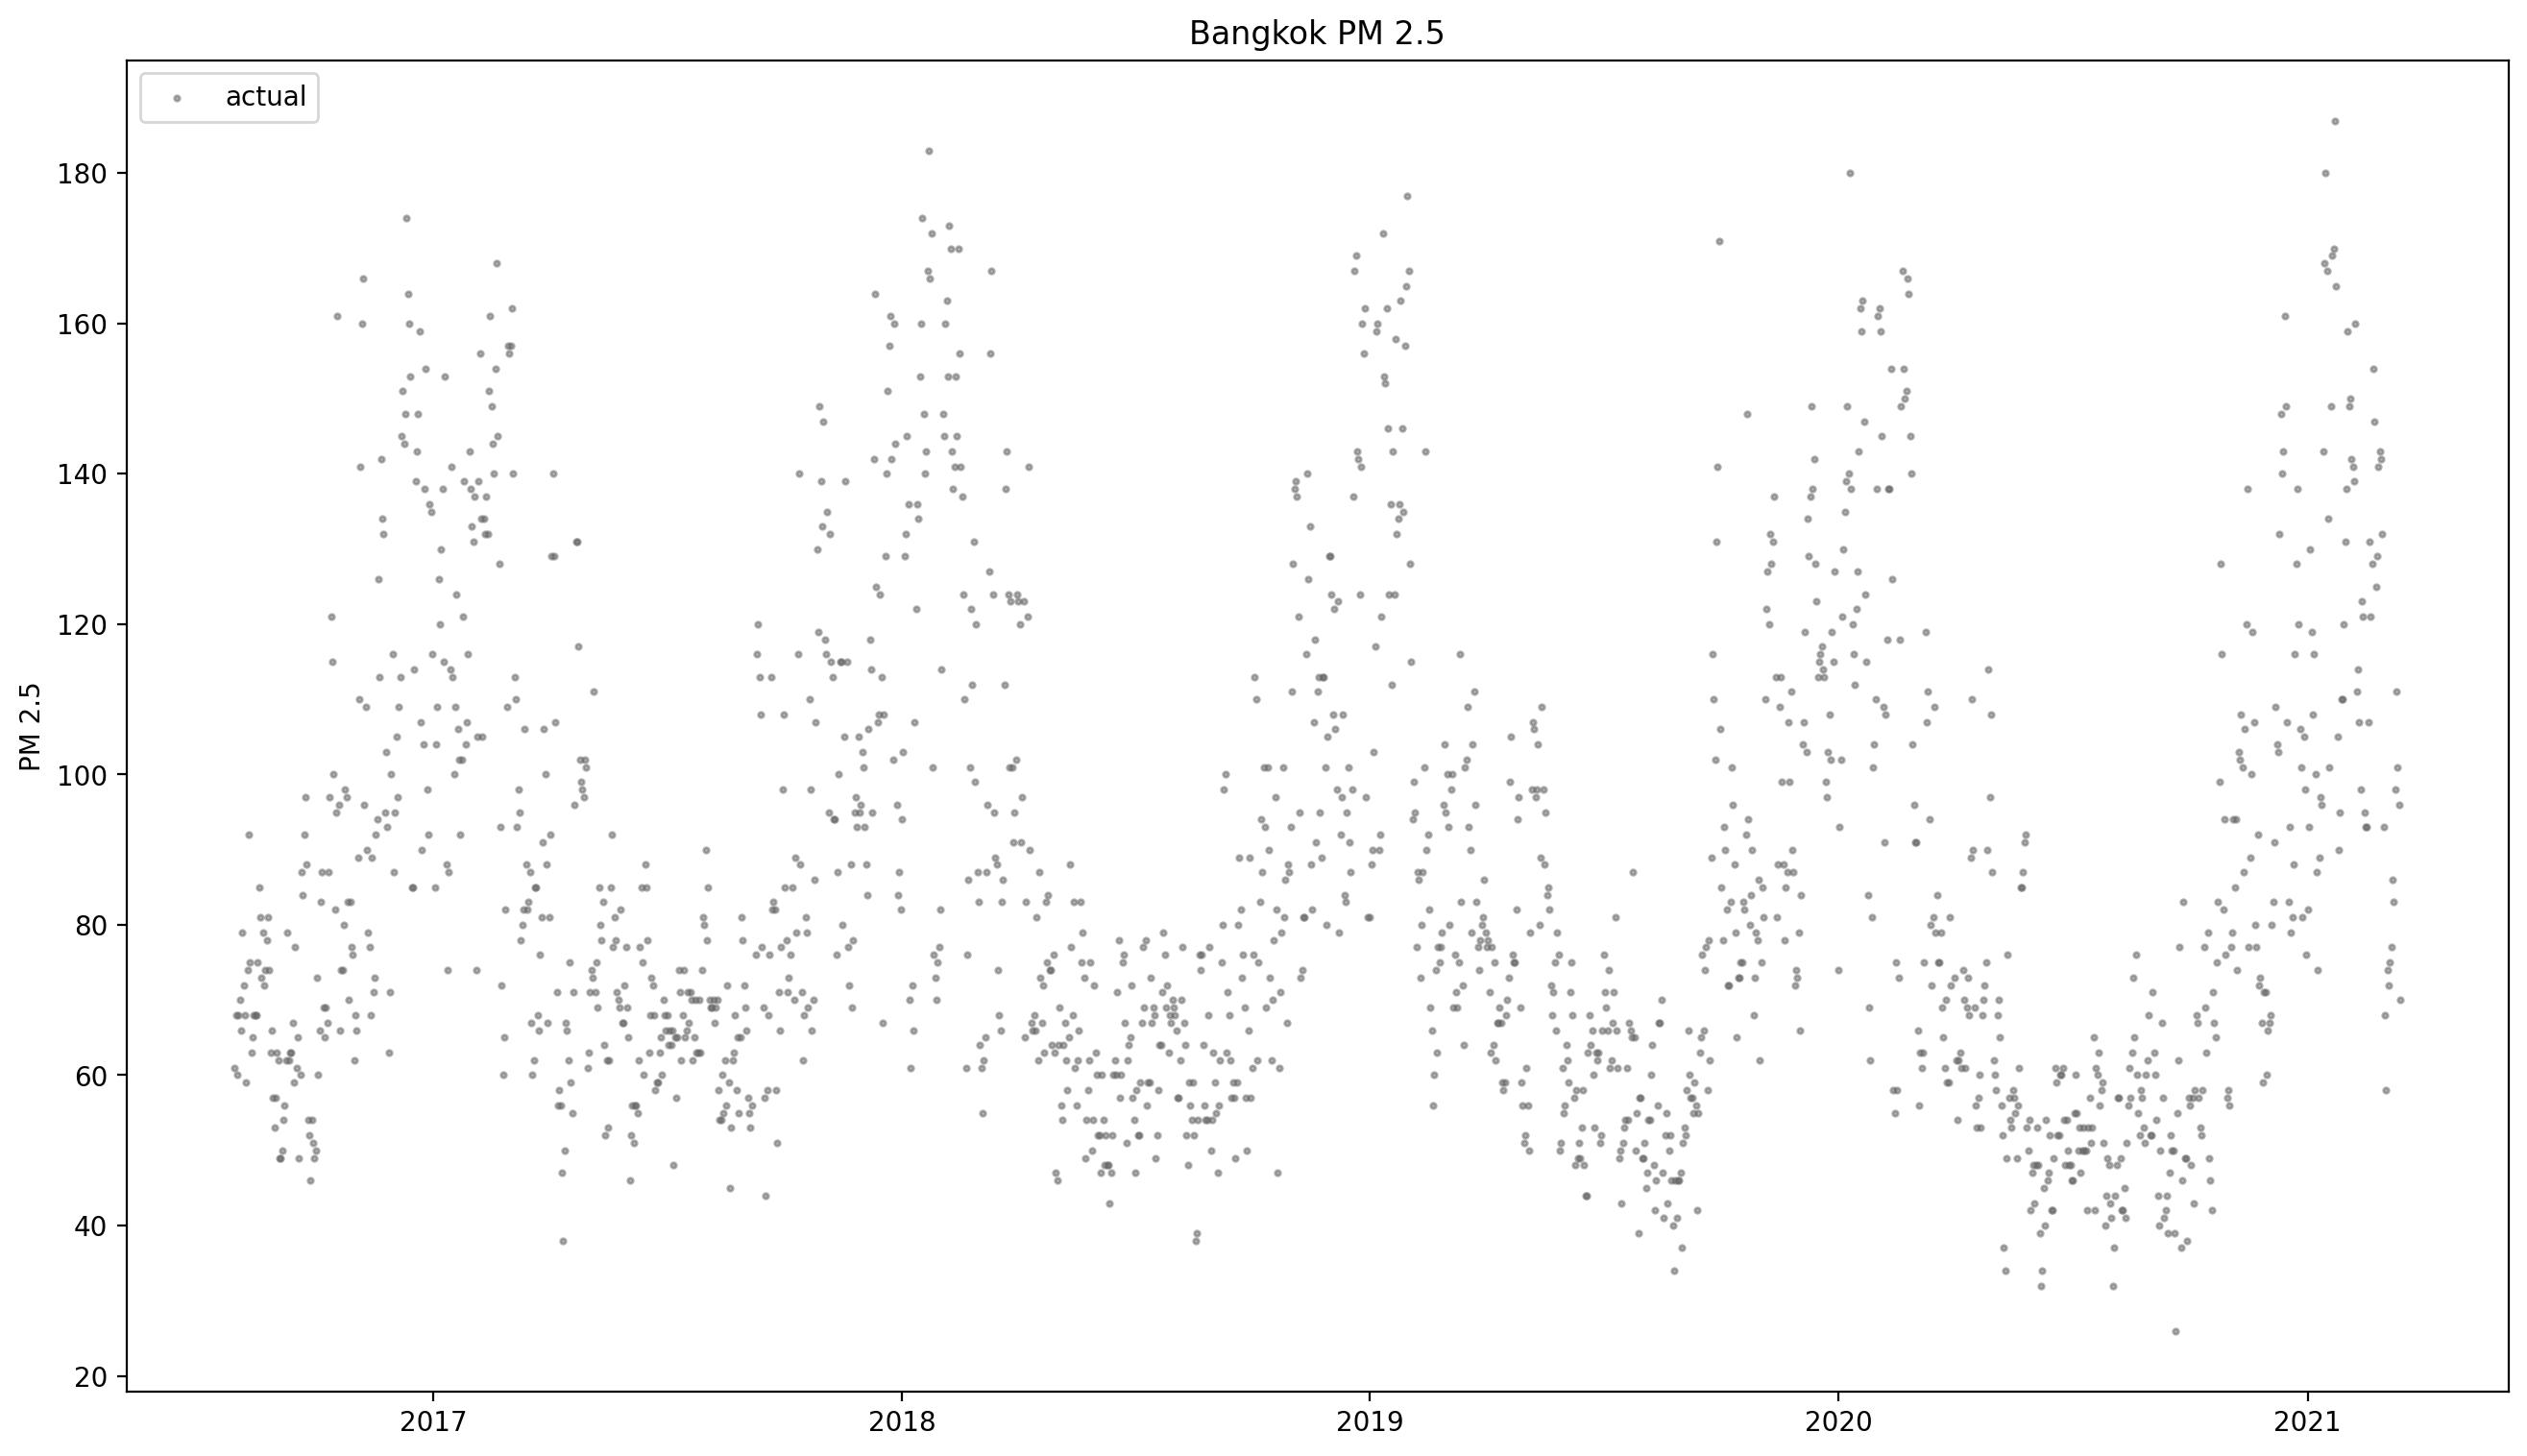

In [15]:
plt.figure(figsize=(16, 9))
plt.scatter(df.index, df[y_col], alpha=.5, s=4, label='actual', color='.4')
plt.ylabel('PM 2.5')
plt.title('Bangkok PM 2.5')
plt.legend();

## lightgbm regressor
* `lightGBM` doc: https://lightgbm.readthedocs.io/en/latest/
* `LGBMRegressor`: https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMRegressor.html


how to install lightgbm
* pip: `pip install -U lightgbm`
* conda: `conda install lightgbm`

In [16]:
feature_cols=[
    'year', 'month', 
    'day', 
    'day_name'
]
X=df[feature_cols]
y=df[y_col]

In [17]:
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y, 
#                                                     test_size=0.10, 
#                                                     random_state=1)

In [18]:
split_at=1400
X_train, X_test, y_train, y_test=X[:split_at], X[split_at:], y[:split_at], y[split_at:]

In [19]:
import lightgbm as lgb
print(f'lightgbm version = {lgb.__version__}')

lightgbm version = 3.3.5


In [20]:
reg = lgb.LGBMRegressor()

In [21]:
reg.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': 'warn',
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [22]:
params={'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
}
# reg = lgb.LGBMRegressor()
# reg = lgb.LGBMRegressor(**params)

In [23]:
fit_params={'early_stopping_rounds':200, 
            'eval_set': [(X_test, y_test)],
            'verbose': 10
           }
reg.fit(X_train, y_train, **fit_params)

[10]	valid_0's l2: 580.816
[20]	valid_0's l2: 459.373
[30]	valid_0's l2: 426.911
[40]	valid_0's l2: 439.496
[50]	valid_0's l2: 443.916
[60]	valid_0's l2: 436.254
[70]	valid_0's l2: 431.686
[80]	valid_0's l2: 430.888
[90]	valid_0's l2: 436.562
[100]	valid_0's l2: 433.875


LGBMRegressor()

In [24]:
reg.__dict__

{'boosting_type': 'gbdt',
 'objective': None,
 'num_leaves': 31,
 'max_depth': -1,
 'learning_rate': 0.1,
 'n_estimators': 100,
 'subsample_for_bin': 200000,
 'min_split_gain': 0.0,
 'min_child_weight': 0.001,
 'min_child_samples': 20,
 'subsample': 1.0,
 'subsample_freq': 0,
 'colsample_bytree': 1.0,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'random_state': None,
 'n_jobs': -1,
 'silent': 'warn',
 'importance_type': 'split',
 '_Booster': <lightgbm.basic.Booster at 0x128bb8090>,
 '_evals_result': {'valid_0': OrderedDict([('l2',
                [1122.2392287398595,
                 1002.9021390432586,
                 908.562189236066,
                 829.8809273311773,
                 765.9384747221143,
                 715.3535553006516,
                 673.609145962601,
                 640.0079607150411,
                 611.0339195751508,
                 580.8155276695235,
                 561.1874070822797,
                 546.4382628313118,
                 526.9601717733285,


In [25]:
reg.score(X_train, y_train)

0.6707731536101429

In [26]:
reg.score(X_test, y_test)

0.6485707602309667

In [27]:
reg.predict(X_test[:5])

array([55.91097635, 56.29014691, 56.3662098 , 54.9632254 , 54.66016763])

## visualize forecast

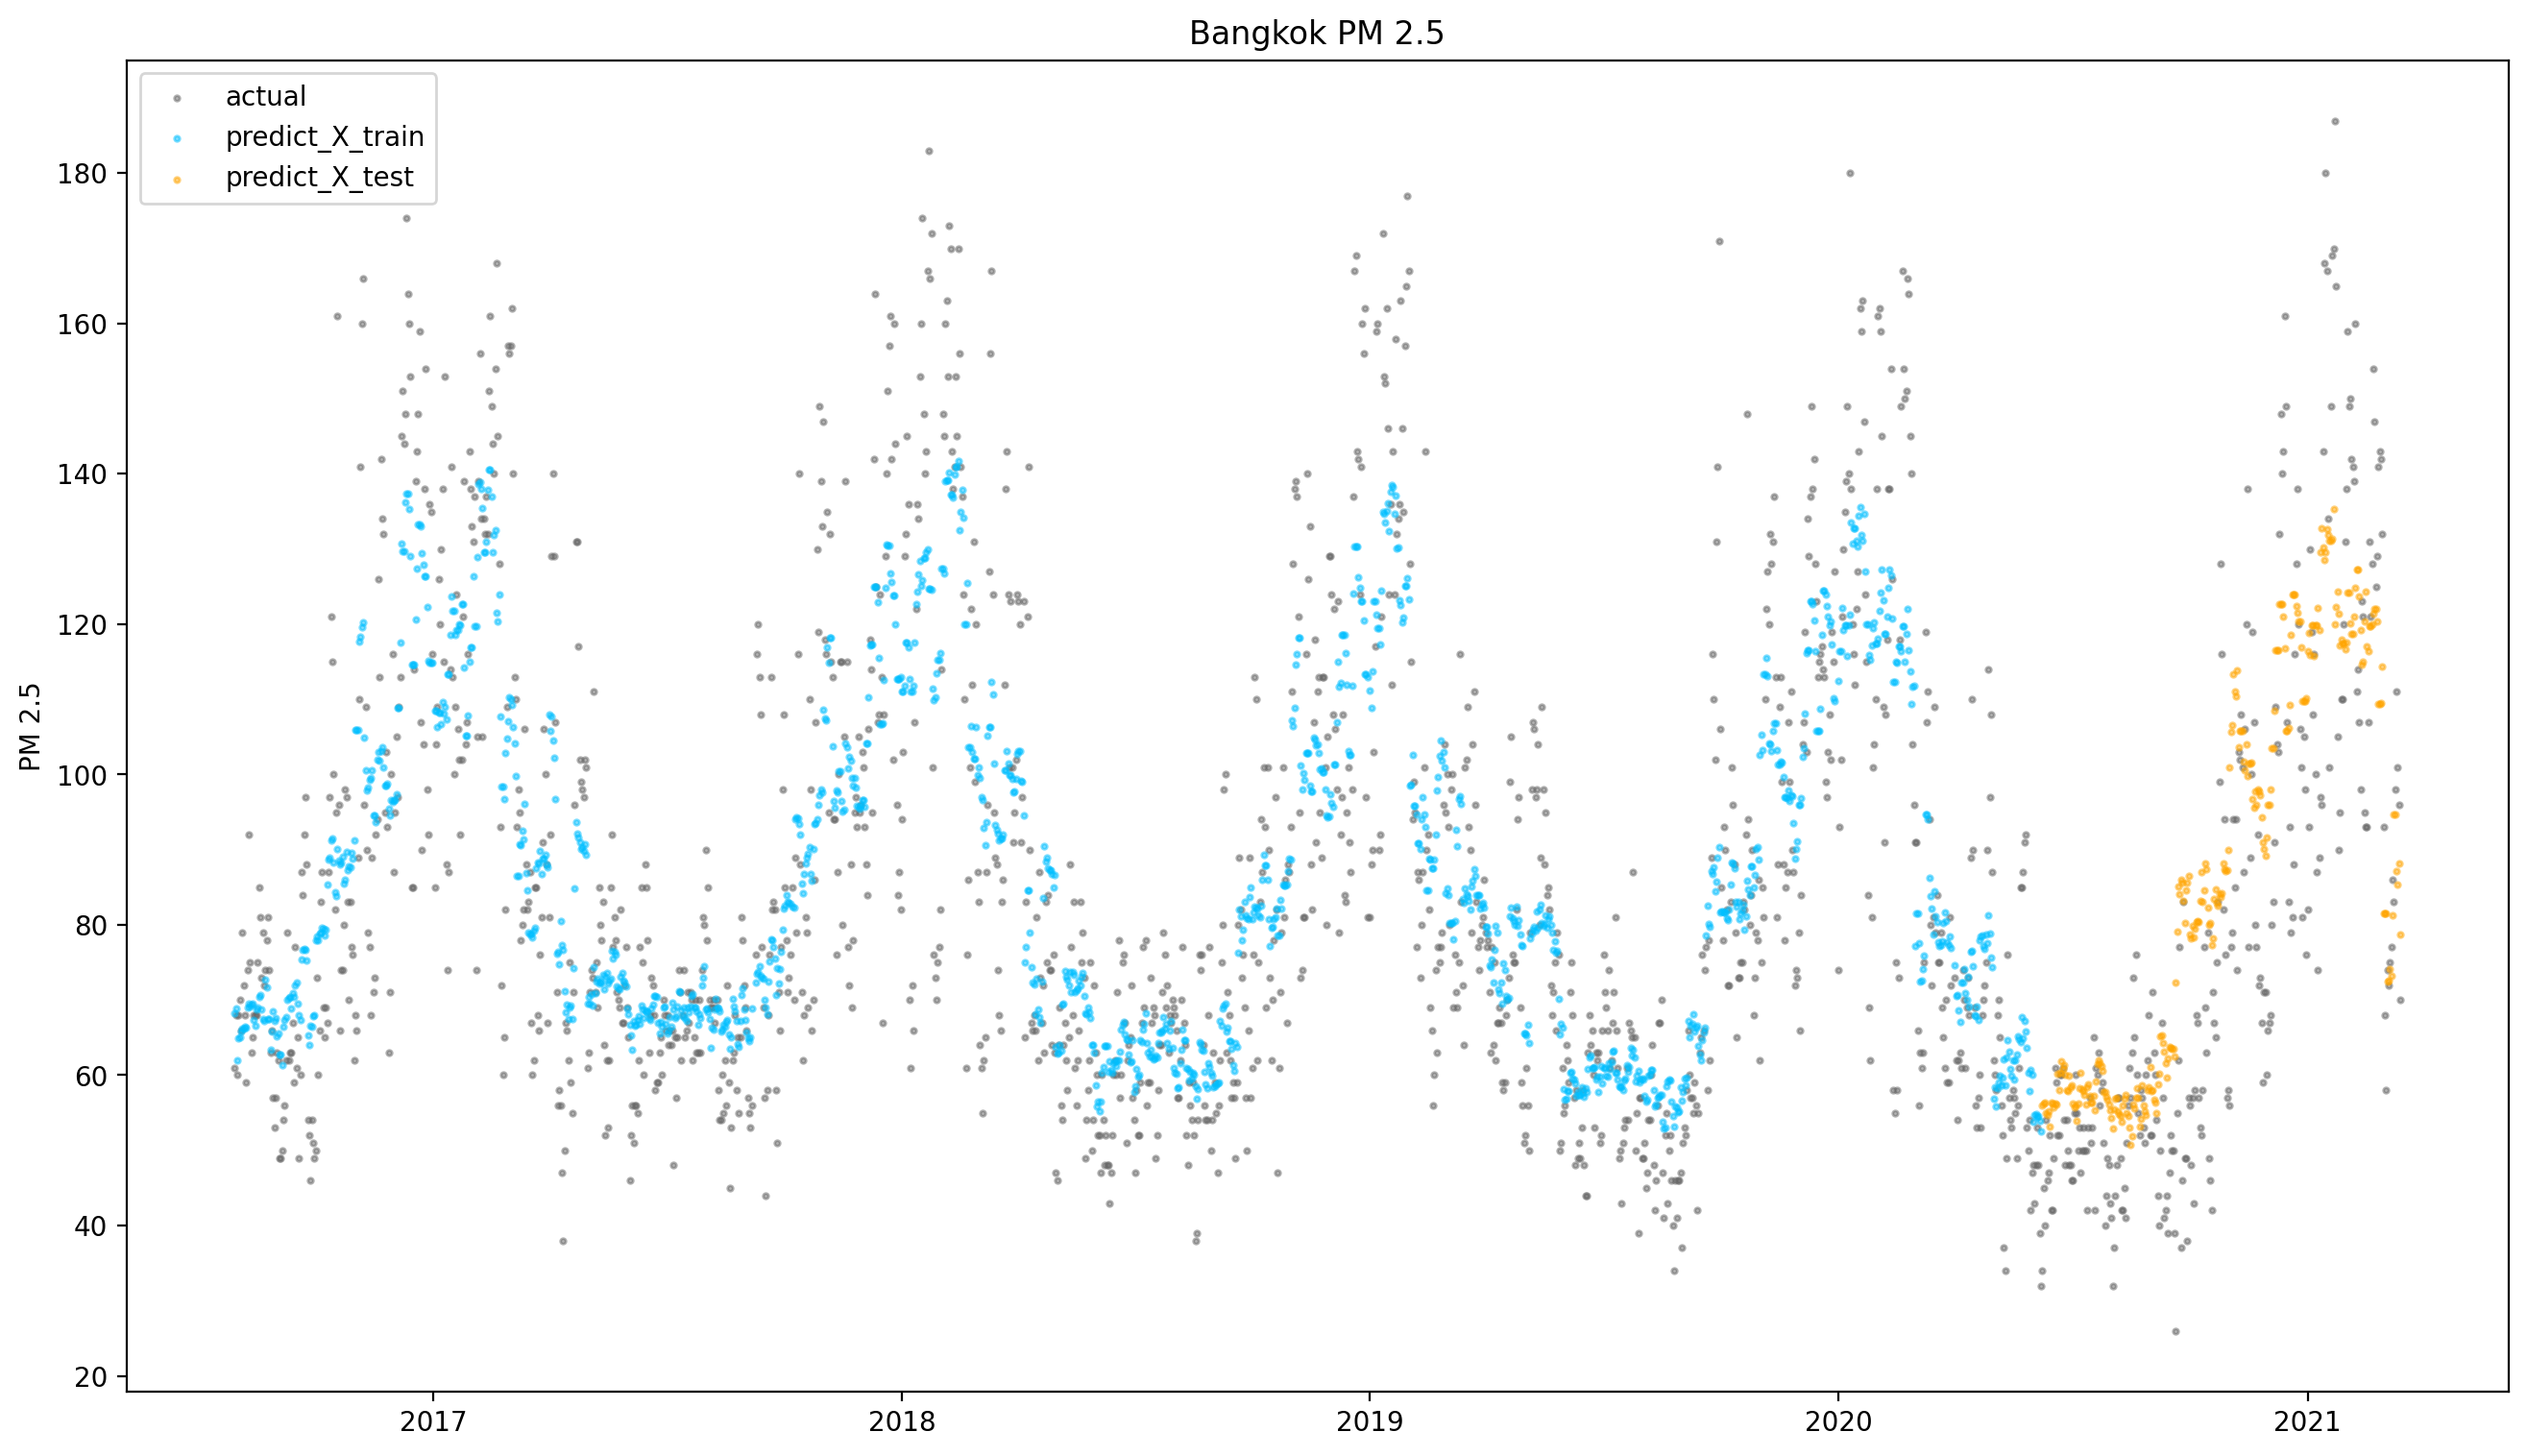

In [28]:
plt.figure(figsize=(16, 9))
plt.scatter(df.index, df[y_col], alpha=.5, s=4, label='actual', color='.4')
plt.scatter(X_train.index, reg.predict(X_train), alpha=.5, s=4, label='predict_X_train', color='deepskyblue')
plt.scatter(X_test.index, reg.predict(X_test), alpha=.5, s=4, label='predict_X_test', color='orange')
plt.ylabel('PM 2.5')
plt.title('Bangkok PM 2.5')
plt.legend();

In [29]:
df

,year,month,day,day_name,pm25
date,,,,,
2016-07-30,2016,7,30,Saturday,61.0
2016-07-31,2016,7,31,Sunday,68.0
2016-08-01,2016,8,1,Monday,60.0
2016-08-02,2016,8,2,Tuesday,68.0
2016-08-03,2016,8,3,Wednesday,70.0
...,...,...,...,...,...
2021-03-10,2021,3,10,Wednesday,98.0
2021-03-11,2021,3,11,Thursday,111.0
2021-03-12,2021,3,12,Friday,101.0


## SHAP
* document: https://github.com/slundberg/shap

In [30]:
import shap
# load JS visualization code to notebook
shap.initjs()

In [31]:
X

,year,month,day,day_name
date,,,,
2016-07-30,2016,7,30,Saturday
2016-07-31,2016,7,31,Sunday
2016-08-01,2016,8,1,Monday
2016-08-02,2016,8,2,Tuesday
2016-08-03,2016,8,3,Wednesday
...,...,...,...,...
2021-03-10,2021,3,10,Wednesday
2021-03-11,2021,3,11,Thursday
2021-03-12,2021,3,12,Friday


In [32]:
X.tail

<bound method NDFrame.tail of             year  month  day   day_name
date                                   
2016-07-30  2016      7   30   Saturday
2016-07-31  2016      7   31     Sunday
2016-08-01  2016      8    1     Monday
2016-08-02  2016      8    2    Tuesday
2016-08-03  2016      8    3  Wednesday
...          ...    ...  ...        ...
2021-03-10  2021      3   10  Wednesday
2021-03-11  2021      3   11   Thursday
2021-03-12  2021      3   12     Friday
2021-03-13  2021      3   13   Saturday
2021-03-14  2021      3   14     Sunday

[1680 rows x 4 columns]>

In [33]:
X.loc[['2021-03-04']]

,year,month,day,day_name
date,,,,
2021-03-04,2021,3,4,Thursday


In [34]:
Xi=pd.DataFrame([[2016,3,17,'Wednesday']])

In [35]:
Xi=np.array([[2016,3,17,6]])

In [36]:
# explain the model's predictions using SHAP
explainer = shap.TreeExplainer(reg)
# shap_values = explainer.shap_values(X.loc[['2021-03-04']])
# shap_values = explainer.shap_values(np.array([[2016,3,17,6]]))
shap_values = explainer.shap_values(X)

In [37]:
shap_values

array([[  1.95637421, -20.60517944,  -0.51331326,   0.15997334],
       [  2.06046771, -20.74330596,   0.05988011,   0.24899098],
       [  2.36670262, -24.33206408,  -2.40446167,  -0.8956949 ],
       ...,
       [ -5.80754521,   1.40428192,   4.72927592,  -2.28054464],
       [ -5.57162891,   2.17271344,   4.47895177,  -0.19113798],
       [ -5.54722362,  -1.14501056,   0.05798703,  -1.92880233]])

In [38]:
explainer.__dict__

{'model': <shap.explainers._tree.TreeEnsemble at 0x12aac5b10>,
 'output_names': None,
 'feature_names': None,
 'masker': None,
 'link': CPUDispatcher(<function identity at 0x129a7cc20>),
 'linearize_link': True,
 'data': None,
 'data_missing': None,
 'feature_perturbation': 'tree_path_dependent',
 'expected_value': 87.29487412518088,
 'model_output': 'raw',
 'approximate': False}

In [39]:
reg.predict(X_train).mean() # explainer.expected_value

87.29487412518088

In [40]:
shap_values[:3]

array([[  1.95637421, -20.60517944,  -0.51331326,   0.15997334],
       [  2.06046771, -20.74330596,   0.05988011,   0.24899098],
       [  2.36670262, -24.33206408,  -2.40446167,  -0.8956949 ]])

In [41]:
shap_values.shape

(1680, 4)

In [42]:
X[:5]

,year,month,day,day_name
date,,,,
2016-07-30,2016,7,30,Saturday
2016-07-31,2016,7,31,Sunday
2016-08-01,2016,8,1,Monday
2016-08-02,2016,8,2,Tuesday
2016-08-03,2016,8,3,Wednesday


In [43]:
feature_cols

['year', 'month', 'day', 'day_name']

In [44]:
# shap values of each case
dshap=pd.DataFrame(shap_values, columns=feature_cols)
dshap

,year,month,day,day_name
0,1.956374,-20.605179,-0.513313,0.159973
1,2.060468,-20.743306,0.059880,0.248991
2,2.366703,-24.332064,-2.404462,-0.895695
3,2.565661,-23.502320,-2.300267,0.822368
4,2.534763,-23.272421,-2.082298,0.566421
...,...,...,...,...
1675,-4.456102,3.751060,6.204670,1.863439
1676,-5.557675,1.732926,5.254939,-1.537204
1677,-5.807545,1.404282,4.729276,-2.280545
1678,-5.571629,2.172713,4.478952,-0.191138


In [45]:
X[:5]

,year,month,day,day_name
date,,,,
2016-07-30,2016,7,30,Saturday
2016-07-31,2016,7,31,Sunday
2016-08-01,2016,8,1,Monday
2016-08-02,2016,8,2,Tuesday
2016-08-03,2016,8,3,Wednesday


In [46]:
X.tail()

,year,month,day,day_name
date,,,,
2021-03-10,2021,3,10,Wednesday
2021-03-11,2021,3,11,Thursday
2021-03-12,2021,3,12,Friday
2021-03-13,2021,3,13,Saturday
2021-03-14,2021,3,14,Sunday


In [47]:
np.abs(dshap).mean().sort_values(ascending=False)

month       19.159725
year         2.720239
day          2.581228
day_name     0.659689
dtype: float64

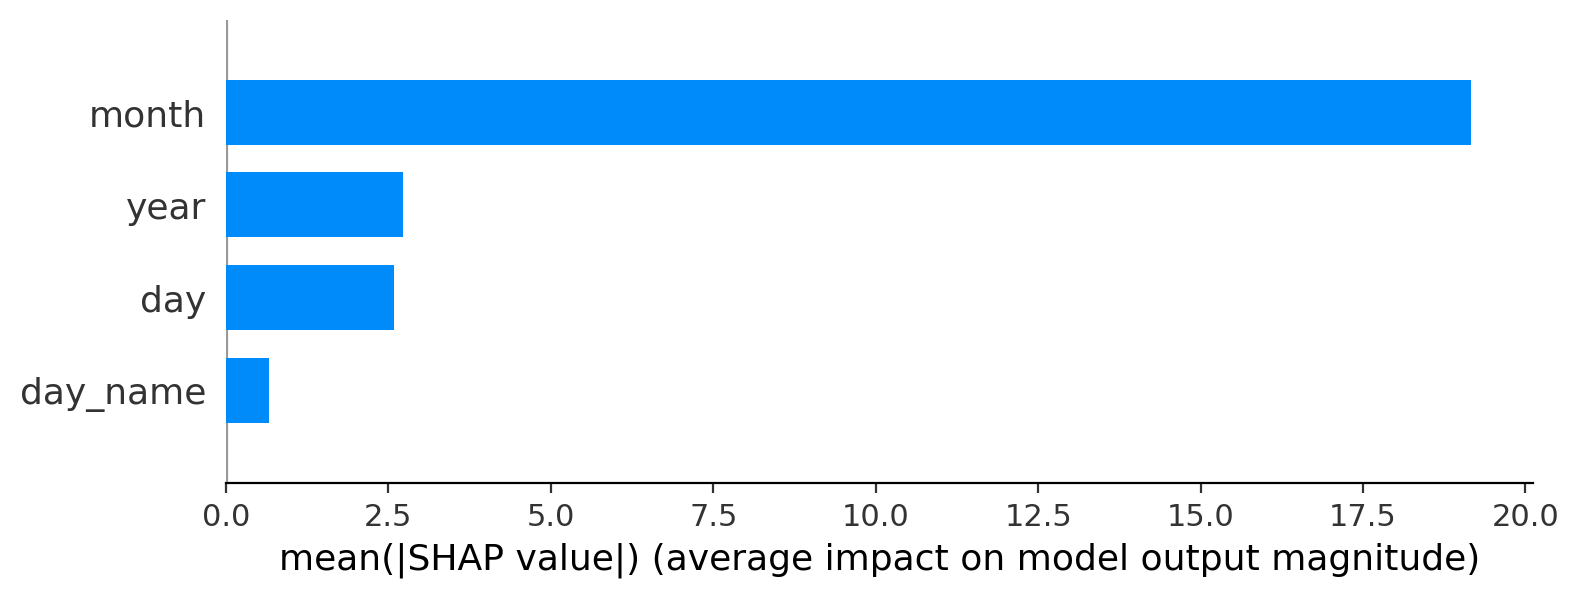

In [48]:
shap.summary_plot(shap_values, X, plot_type="bar")

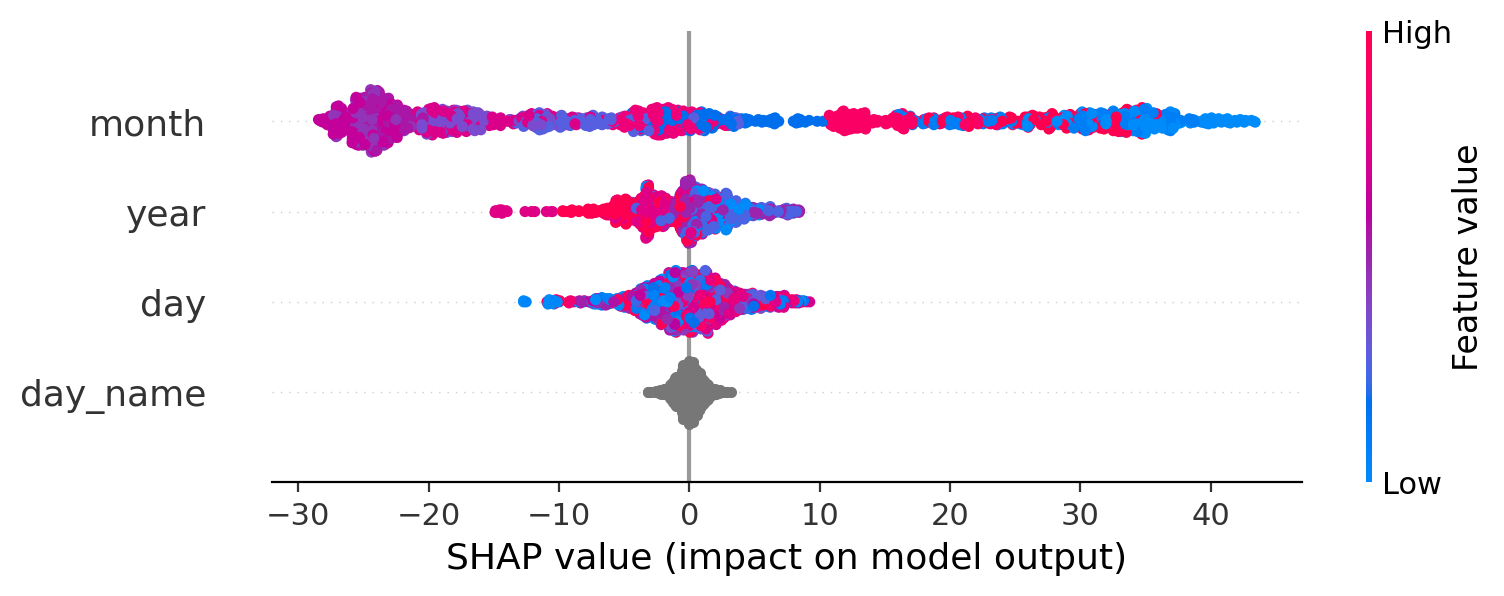

In [49]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X)

In [50]:
explainer.shap_values(X)

array([[  1.95637421, -20.60517944,  -0.51331326,   0.15997334],
       [  2.06046771, -20.74330596,   0.05988011,   0.24899098],
       [  2.36670262, -24.33206408,  -2.40446167,  -0.8956949 ],
       ...,
       [ -5.80754521,   1.40428192,   4.72927592,  -2.28054464],
       [ -5.57162891,   2.17271344,   4.47895177,  -0.19113798],
       [ -5.54722362,  -1.14501056,   0.05798703,  -1.92880233]])

In [51]:
def case_detail(case_data):
    '''
    format obj returned from shap.force_plot()
    '''
    de=pd.DataFrame(case_data.data['features'])
    fcols=[]
    for i in case_data.data['features'].keys():
        fcols.append(case_data.data['featureNames'][i])
    de.columns=fcols
    return de

def individual_case_plot(explainer, X, case_index):
    """
    >>> individual_case_plot(explainer, X_train, 1)
    """
    shap_values = explainer.shap_values(X.iloc[[case_index]])
    g=shap.force_plot(explainer.expected_value, shap_values=shap_values, features=X.iloc[case_index, :])
    
#     shap_values = explainer.shap_values(X)
#     g=shap.force_plot(explainer.expected_value, shap_values=shap_values[case_index], features=X.iloc[case_index, :])
#     print('SHAP values')
#     dshap=pd.DataFrame(shap_values, columns=feature_cols)
#     dpos=dshap.iloc[case_index][dshap.iloc[case_index].values > 0].sort_values(ascending=False)
#     dneg=dshap.iloc[case_index][dshap.iloc[case_index].values < 0].sort_values(ascending=False)
#     print(dpos)
#     print(f'sum pos = {dpos.sum():.6f}')
#     print(dneg)
#     print(f'sum neg = {dneg.sum():.6f}')

#     print(f'sum SHAP = {dpos.sum()+dneg.sum():.6f}')
#     print(f'base      value = {explainer.expected_value:.2f}')
#     print(f'predicted value = {explainer.expected_value + dpos.sum() + dneg.sum():.2f}')
#     pprint(g.data)
    return g

In [52]:
X[:3]

,year,month,day,day_name
date,,,,
2016-07-30,2016,7,30,Saturday
2016-07-31,2016,7,31,Sunday
2016-08-01,2016,8,1,Monday


In [53]:
X.iloc[[3]]

,year,month,day,day_name
date,,,,
2016-08-02,2016,8,2,Tuesday


In [54]:
individual_case_plot(explainer, X, 0)

In [55]:
g=individual_case_plot(explainer, X, 0)
g

In [56]:
g.__dict__

{'data': {'outNames': ['f(x)'],
  'baseValue': 87.29487412518088,
  'outValue': 68.29272897367474,
  'link': 'identity',
  'featureNames': ['year', 'month', 'day', 'day_name'],
  'features': {0: {'effect': 1.9563742111270237, 'value': 2016.0},
   1: {'effect': -20.605179437561063, 'value': 7.0},
   2: {'effect': -0.5133132633212985, 'value': 30.0},
   3: {'effect': 0.15997333824920065, 'value': 'Saturday'}},
  'plot_cmap': 'RdBu',
  'labelMargin': 20}}

In [57]:
de=case_detail(g)
de

,year,month,day,day_name
effect,1.956374,-20.605179,-0.513313,0.159973
value,2016.000000,7.000000,30.000000,Saturday


In [58]:
de.loc['effect', :].sum()

-19.002145151506134

In [59]:
de.loc['effect', :].sum()+g.data['baseValue']

68.29272897367474

In [60]:
sum_effect=0
for k, v in g.data['features'].items():
    sum_effect+=v['effect']
sum_effect

-19.002145151506134

In [61]:
g.data['baseValue'] + sum_effect

68.29272897367474

In [62]:
g=individual_case_plot(explainer, X, 120)
g

In [63]:
case_detail(g)

,year,month,day,day_name
effect,0.647185,12.123129,-4.205979,-0.406407
value,2016.000000,11.000000,27.000000,Sunday


In [64]:
shap.force_plot(explainer.expected_value, shap_values[:365], X[:365])

In [63]:
X

,year,month,day,day_name
date,,,,
2016-07-30,2016,7,30,Saturday
2016-07-31,2016,7,31,Sunday
2016-08-01,2016,8,1,Monday
2016-08-02,2016,8,2,Tuesday
2016-08-03,2016,8,3,Wednesday
...,...,...,...,...
2021-03-10,2021,3,10,Wednesday
2021-03-11,2021,3,11,Thursday
2021-03-12,2021,3,12,Friday
